In [15]:
#Import required libraries
import pandas as pd 
import numpy as np
from datetime import datetime
import gurobipy as gp
import warnings
warnings.filterwarnings("ignore")
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


### Loading the 2019 and 2020 file and initializing variables

In [16]:
#loading the required datasets
df_2019 = pd.read_csv('https://raw.githubusercontent.com/KshitijMahajan1998/Optimization/main/stocks2019.csv')
df_2020 = pd.read_csv('https://raw.githubusercontent.com/KshitijMahajan1998/Optimization/main/stocks2020.csv')

#setting the time limit 
time = 3600


In [17]:
#calculating the number of stocks in the data  
num_stocks = len(df_2019.columns) - 2

# creating array for m values 
m_values = [5,10,20,30,40,50,60,70,80,90,100]
m = [x for x in m_values if x <= num_stocks]

#renaming the first column to date 
df_2019.rename(columns = {list(df_2019)[0] : 'Date'}, inplace = True)
df_2020.rename(columns = {list(df_2020)[0] : 'Date'}, inplace = True)

# Convert the 'Date' column into a datetime object
df_2019['Date'] = pd.to_datetime(df_2019['Date'])
df_2020['Date'] = pd.to_datetime(df_2020['Date'])

# Set 'Date' as the index
df_2019.set_index('Date', inplace=True)
df_2020.set_index('Date', inplace=True)

### Calculating the stock return similarity matrix

In [18]:
#creating a dataframe containing daily returns of stocks 
df_2019_returns = df_2019/df_2019.shift(1) - 1

#calculating correlation between different stocks and creating the matrix
df_corr = df_2019_returns.corr().iloc[1:,1:]

## 1. Stock Allocation

#### Objective Function
$$\underset{x,y}{max}\sum_{i=1}^{n}\sum_{j=1}^{n}\rho _{ij}x_{ij}$$

In [19]:
#creating objective array 
N = len(df_corr)
obj = np.zeros(N**2 + N) # N**2 + N represents number of decision variables 

#filling in the values in objective array 
index = 0 
for i in df_corr.columns:
    for j in df_corr.columns:
        obj[index] = df_corr.loc[i,j]
        index += 1

In [20]:
#initializing constraints, and directions
A = np.zeros((1 + N + N**2,N**2 + N))
b = np.zeros(1 + N + N**2)
direction = np.array(['']*(1 + N + N**2))

#### Constraint 1 - Limiting the number of selected stocks to m
$$\sum_{j=1}^{n} y_{j} = m$$

In [21]:
#1st constraint -- limiting the number of selected stocks to m 
A[0,N**2:] = 1
direction[0] = '='

#### Constraint 2 - Limiting the similar stock count to 1
$$\sum_{j=1}^{n} x_{ij} = 1 \: for\: i = 1,2,....n$$

In [22]:
#2nd constraint -- limiting the similar stock count to 1 
row = 1 
ind_vec = np.array(range(N))
for i in range(N):
    A[row, i*N + ind_vec] = 1
    b[row] = 1 
    direction[row] = '='
    row += 1

#### Constraint 3 - Making sure best stock representation is in fund
$$x_{ij} \leq y_{ij} \:for\: i,j = 1,2....n$$

In [23]:
#3rd constraint -- making sure best stock representation is present in fund 
A[N+1:,0:(N**2)] = np.diag(np.ones(N*N))

for i in range(N):
    A[(N+1+(i*N)):(N+1+(i*N)+100),N**2:] = -(np.diag(np.ones(N)))

b[row : row + N*N] = 0
direction[row : row + N*N] = '<'

### Performing stock selection for m = 5,10,...100

In [24]:
#initializing a variable to save optimal decision variable values 
stock_selection = {}

for i in m:
    b[0] = i
    tspMod = gp.Model()
    tspMod_x = tspMod.addMVar(N**2 + N,vtype=['B']*(N**2 + N)) 
    tspMod_con = tspMod.addMConstrs(A, tspMod_x, direction, b)
    tspMod.setMObjective(None,obj,0,sense=gp.GRB.MAXIMIZE)
    tspMod.Params.OutputFlag = 0 # tell gurobi to shut up!!
    tspMod.optimize()
    stock_selection[i] = tspMod.x[N**2:]

## 2. Calculating Portfolio Weights for m=5

#### Filtering for the selected stocks

In [36]:
#identifying the selected stocks 
selected_stocks = np.array(stock_selection[5])
selected_stocks

array([-0., -0.,  0.,  0., -0., -0.,  0.,  0.,  0., -0.,  0.,  0., -0.,
       -0.,  0., -0.,  0.,  0., -0., -0., -0., -0.,  0.,  0., -0., -0.,
       -0., -0., -0.,  0., -0.,  0.,  0., -0., -0.,  0., -0.,  0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0.,  0.,  1., -0., -0.,  1., -0., -0., -0.,  1., -0.,
       -0.,  0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,  0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0.,  0., -0., -0., -0., -0.,
       -0., -0., -0.,  1., -0., -0., -0.,  1., -0.])

#### Objective Function
$$\underset{w}{min} \sum_{t=1}^{T}\left | q_{t} - \sum_{i=1}^{m}w_{i}r_{it} \right |$$

In [26]:
#creating the objective array
N = len(df_2019) - 1
obj = np.zeros(sum(selected_stocks.astype(int)) + N)
obj[0:N] = 1

In [27]:
# creating constraints 
n_var = sum(selected_stocks.astype(int)) + N
A = np.zeros((N*2+1, n_var))
b = np.zeros(N*2+1)
direction = np.array(['']*(N*2+1))

#### Constraint 1 - Sum of weights of all the selected stocks = 1 
$$ \sum_{i=1}^{m}w_{i} = 1$$

In [28]:
#constraint 1
A[0,N:] = 1 
b[0] = 1
direction[0] = '='

#### Remaining Constraints - Convert the objective function to linear program

In [29]:
# remaining constraints 
q = df_2019_returns[['NDX']]
r = df_2019_returns[df_2019_returns.columns[1:].values[selected_stocks.astype(bool)]]

A[1:N+1,0:N] = np.diag(np.ones(N))
A[N+1:,0:N] = -(np.diag(np.ones(N)))
for i in range(N):
    A[i+1,N:] = r.reset_index().drop(columns = 'Date').iloc[i+1].values
    b[i+1] = q.reset_index().drop(columns = 'Date').iloc[i+1].values
    direction[i+1] = '>'
    A[N+1+i, N:] = r.reset_index().drop(columns = 'Date').iloc[i+1].values
    b[N+1+i] = q.reset_index().drop(columns = 'Date').iloc[i+1].values
    direction[N+1+i] = '<' 

In [31]:
tspMod = gp.Model()
tspMod_x = tspMod.addMVar(int(n_var)) 
tspMod_con = tspMod.addMConstrs(A, tspMod_x, direction, b)
tspMod.setMObjective(None,obj,0,sense=gp.GRB.MINIMIZE)

tspMod.Params.OutputFlag = 0 # tell gurobi to shut up!!
tspMod.optimize()

#### Comparing fund performance with 2020 data based on the below formula
$$ \sum_{t=1}^{T}\left | q_{t} - \sum_{i=1}^{5}w_{i}r_{it} \right |$$

In [17]:
#calculating 2020 returns matrix 
df_2020_returns = df_2020/df_2020.shift(1) - 1 

#identifying the selected stocks 
selected_stocks = np.array(stock_selection[5])

#filtering df_2020 for these stocks 
df_2020_m = df_2020_returns[df_2020_returns.columns[1:].values[selected_stocks.astype(bool)]]
df_2020_index = df_2020_returns[['NDX']]
df_2019_index = df_2019_returns[['NDX']]

# calculating performance score 
for i in range(5):
    df_2020_m.iloc[:,i] = df_2020_m.iloc[:,i]*tspMod.x[N+i]

df_2020_m['return_sum'] = df_2020_m.sum(axis = 1)
df_2020_m = df_2020_m.merge(df_2020_index, left_index = True, right_index = True)
df_2020_m['return_diff'] = np.abs(df_2020_m['NDX'] - df_2020_m['return_sum'])
print('Performance score of this fund (m = 5) based on the above equation is {}.'.format(round(df_2020_m['return_diff'].sum(),2)))

Performance score of this fund (m = 5) based on the above equation is 0.87.


#### Tracking daily 2020 returns of index vs our fund with m = 5 stocks selected

Text(0.5, 1.0, 'Tracking daily 2020 returns of index vs our fund with 5 selected stocks ')

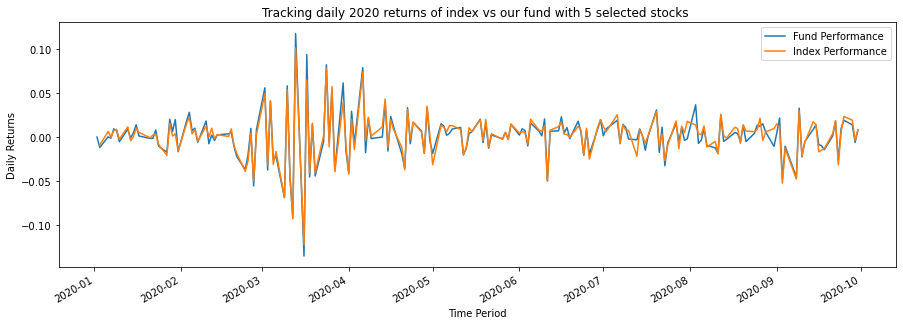

In [18]:
#Tracking daily returns of 2020 index vs our fund with m = 5 stocks selected 
figure(figsize=(15, 5))
df_2020_m['return_sum'].plot(label = 'Fund Performance')
df_2020_m['NDX'].plot(label = 'Index Performance')
legend()
xlabel('Time Period')
ylabel('Daily Returns')
title('Tracking daily 2020 returns of index vs our fund with 5 selected stocks ')

## 3. Replicating the same task for m = 10,20.....100

In [19]:
#defining a dataframe to store performance values 
df_performance = pd.DataFrame(columns = ['2019','2020'], index = m)

#calculating the performing score 
for i in m:    
    
    #filtering for selected stocks 
    selected_stocks = np.array(stock_selection[i])
    
    #creating objective array 
    obj = np.zeros(sum(selected_stocks.astype(int)) + N)
    obj[0:N] = 1
    
    #creating constraints 
    n_var = sum(selected_stocks.astype(int)) + N
    A = np.zeros((N*2+1, n_var))
    b = np.zeros(N*2+1)
    direction = np.array(['']*(N*2+1))
    
    #constraint 1 
    A[0,N:] = 1 
    b[0] = 1
    direction[0] = '='
    
    #remaining constraints 
    A[1:N+1,0:N] = np.diag(np.ones(N))
    A[N+1:,0:N] = -(np.diag(np.ones(N)))
    r = df_2019_returns[df_2019_returns.columns[1:].values[selected_stocks.astype(bool)]]
    for j in range(N):
        A[j+1,N:] = r.reset_index().drop(columns = 'Date').iloc[j+1].values
        b[j+1] = q.reset_index().drop(columns = 'Date').iloc[j+1].values
        direction[j+1] = '>'
        A[N+1+j, N:] = r.reset_index().drop(columns = 'Date').iloc[j+1].values
        b[N+1+j] = q.reset_index().drop(columns = 'Date').iloc[j+1].values
        direction[N+1+j] = '<' 
    
    #solving the optimization problem 
    tspMod = gp.Model()
    tspMod_x = tspMod.addMVar(int(n_var)) 
    tspMod_con = tspMod.addMConstrs(A, tspMod_x, direction, b)
    tspMod.setMObjective(None,obj,0,sense=gp.GRB.MINIMIZE)
    tspMod.Params.OutputFlag = 0 # tell gurobi to shut up!!
    tspMod.optimize()
    
     #calculating performance on 2020 data  
    
    selected_stocks = np.array(stock_selection[i])
    df_2020_m = df_2020_returns[df_2020_returns.columns[1:].values[selected_stocks.astype(bool)]]
    for j in range(i):
        df_2020_m.iloc[:,j] = df_2020_m.iloc[:,j]*tspMod.x[N+j]
    df_2020_m['return_sum'] = df_2020_m.sum(axis = 1)
    df_2020_m = df_2020_m.merge(df_2020_index, left_index = True, right_index = True)
    df_2020_m['return_diff'] = np.abs(df_2020_m['NDX'] - df_2020_m['return_sum'])
    df_performance.loc[i,'2020'] = df_2020_m['return_diff'].sum()
    
    #calculating performance on 2019 data 
    df_2019_m = df_2019_returns[df_2019_returns.columns[1:].values[selected_stocks.astype(bool)]]
    for j in range(i):
        df_2019_m.iloc[:,j] = df_2019_m.iloc[:,j]*tspMod.x[N+j]
    df_2019_m['return_sum'] = df_2019_m.sum(axis = 1)
    df_2019_m = df_2019_m.merge(df_2019_index, left_index = True, right_index = True)
    df_2019_m['return_diff'] = np.abs(df_2019_m['NDX'] - df_2019_m['return_sum'])
    df_performance.loc[i,'2019'] = df_2019_m['return_diff'].sum()

#### Tracking # of stocks in fund (m) vs. the fund performance

Text(0.5, 1.0, 'Fund Performance vs. # of selected stocks (m)')

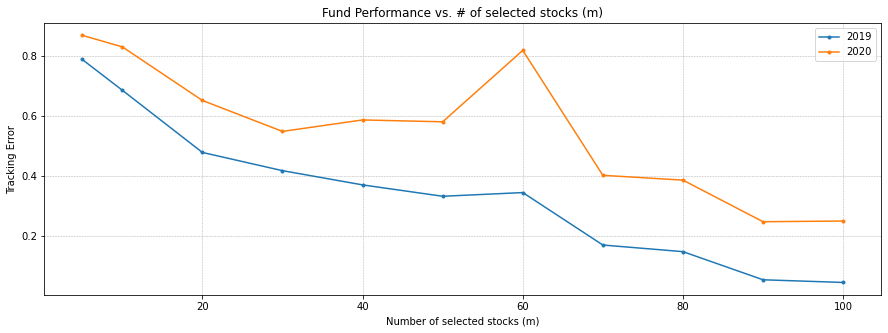

In [20]:
#Tracking m vs. fund performance 
figure(figsize=(15, 5))
plot(df_performance.index,df_performance['2019'], marker = '.', label = '2019')
plot(df_performance.index,df_performance['2020'], marker = '.', label = '2020')
grid(linestyle = '--', linewidth = 0.5)
legend()
xlabel('Number of selected stocks (m)')
ylabel('Tracking Error')
title('Fund Performance vs. # of selected stocks (m)')

## 4. Directly solving MIP

#### Objective Function
$$\underset{w}{min} \sum_{t=1}^{T}\left | q_{t} - \sum_{i=1}^{n}w_{i}r_{it} \right |$$

In [21]:
#creating the objective array 
N = len(df_2019) - 1 # number of time periods 
n = len(df_corr) #number of stocks 
obj = np.zeros(N + n + n) #function to be minimized + weights of stocks (w) + selection variable for each stock (y)
obj[0:N] = 1

In [22]:
# creating constraints 
n_var = N + n + n
A = np.zeros((n+1+1+N*2, n_var))
b = np.zeros(n+1+1+N*2)
direction = np.array(['']*(n+1+1+N*2))

#### Constraint 1 
$$\sum_{j=1}^{n} y_{j} = m$$

In [23]:
#1st constraint -- limiting the number of selected stocks to m 
A[0,N+n:] = 1 
direction[0] = '='

#### Constraint 2 - Wi = 0 if yi = 0
$$w_{i} \leq y_{i}$$

In [24]:
#2nd constraint - wi = 0 if yi = 0, big M = 1 
A[1:n+1,N:N+n] = np.diag(np.ones(n))
A[1:n+1,N+n:] = -(np.diag(np.ones(n)))
direction[1:n+1] = '<'

#### Constraint 3 - Sum of weights = 1 
$$ \sum_{i=1}^{m}w_{i} = 1$$

In [25]:
# 3rd constraint - sum of w = 1 
A[n+1,N:N+n] = 1
b[n+1] = 1
direction[n+1] = '='

#### Remaining Constraints - Convert the objective function to linear program

In [26]:
# 4th Constraint - converting to LP 
A[n+1+1:n+1+1+N,0:N] = np.diag(np.ones(N)) #coefficient of y 
A[n+1+1+N:,0:N] = -(np.diag(np.ones(N))) #coefficient of y 

for i in range(N):
    A[i+n+1+1,N:N+n] = df_2019_returns.reset_index().drop(columns = ['Date', 'NDX']).iloc[i+1]
    b[i+n+1+1] = q.reset_index().drop(columns = 'Date').iloc[i+1].values
    direction[i+n+1+1] = '>'
    A[i+n+1+1+N,N:N+n] = df_2019_returns.reset_index().drop(columns = ['Date', 'NDX']).iloc[i+1]
    b[i+n+1+1+N] = q.reset_index().drop(columns = 'Date').iloc[i+1].values
    direction[i+n+1+1+N] = '<'

#### Solving the MIP!

In [27]:
#initializing variable to store the objective value 
objvalues = []

#solving the MIP for each value of m
for i in m:
    b[0] = i
    tspMod = gp.Model()
    tspMod_x = tspMod.addMVar(len(obj), vtype = ['C']*(N+n) + ['B']*n) 
    tspMod_con = tspMod.addMConstrs(A, tspMod_x, direction, b)
    tspMod.setMObjective(None,obj,0,sense=gp.GRB.MINIMIZE)

    tspMod.Params.OutputFlag = 0 # tell gurobi to shut up!!
    tspMod.params.TimeLimit = time
    tspMod.optimize()
    objvalues.append(tspMod.objval)
    pd.DataFrame(tspMod.x).to_excel('obj_values_{}.xlsx'.format(i))   


#### Tracking Performance Score with 2019 and 2020 data

In [28]:
df_performance_mip = pd.DataFrame(columns = ['2019','2020'], index = m)

for i in m:
    
    #creating a copy of 2019 daily returns df 
    df_returns_m = df_2019_returns.copy()
    
    #creating a copy of 2020 daily returns df 
    df_returns_m_2020 = df_2020_returns.copy()
    
    #loading the objective values from excel 
    df = np.array(pd.read_excel('obj_values_{}.xlsx'.format(i)).iloc[:,1])[N:N+n]
     
    #calculating performance on 2019 data 
    for j in range(n):
        df_returns_m.iloc[:,j+1] = df_returns_m.iloc[:,j+1]*df[j]
        
    df_returns_m['return_sum'] = df_returns_m.iloc[:,1:].sum(axis = 1)
    df_returns_m['return_diff'] = np.abs(df_returns_m['NDX'] - df_returns_m['return_sum'])
    df_performance_mip.loc[i,'2019'] = df_returns_m['return_diff'].sum()

    #calculating performance on 2020 data 
    for j in range(n):
        df_returns_m_2020.iloc[:,j+1] = df_returns_m_2020.iloc[:,j+1]*df[j]
        
    df_returns_m_2020['return_sum'] = df_returns_m_2020.iloc[:,1:].sum(axis = 1)
    df_returns_m_2020['return_diff'] = np.abs(df_returns_m_2020['NDX'] - df_returns_m_2020['return_sum'])
    df_performance_mip.loc[i,'2020'] = df_returns_m_2020['return_diff'].sum()

## Comparing the fund performance vs. number of stocks (m) for - 
### (i) Solving 1 IP and 1 LP   
### (ii) Solving 1 MIP

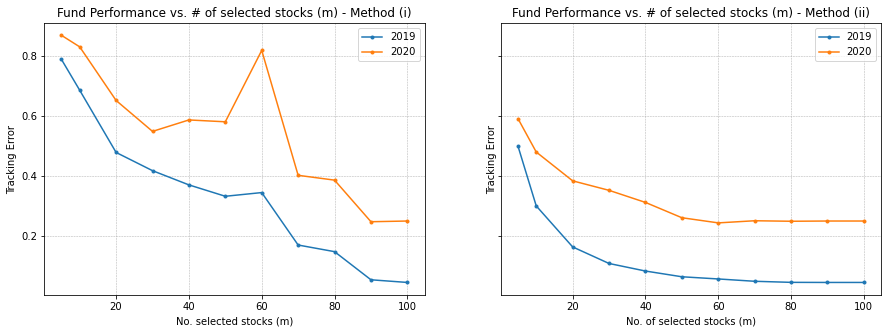

In [30]:
fig, (ax1, ax2) = subplots(nrows=1,ncols=2,sharey=True,figsize=(15, 5))

ax1.plot(df_performance.index,df_performance['2019'], marker = '.', label = '2019')
ax1.plot(df_performance.index,df_performance['2020'], marker = '.', label = '2020')
ax1.legend()
ax1.set_xlabel('No. selected stocks (m)')
ax1.set_ylabel('Tracking Error')
ax1.set_title('Fund Performance vs. # of selected stocks (m) - Method (i)')
ax1.grid(linestyle = '--', linewidth = 0.5)
ax2.plot(df_performance_mip.index,df_performance_mip['2019'], marker = '.', label = '2019')
ax2.plot(df_performance_mip.index,df_performance_mip['2020'], marker = '.', label = '2020')
ax2.legend()
ax2.set_xlabel('No. of selected stocks (m)')
ax2.set_ylabel('Tracking Error')
ax2.set_title('Fund Performance vs. # of selected stocks (m) - Method (ii)')
ax2.grid(linestyle = '--', linewidth = 0.5)